In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.datasets import load_digits
from sklearn import datasets
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

from pytorch_model_summary import summary

https://data-science-blog.com/blog/2022/03/15/deep-autoregressive-models/

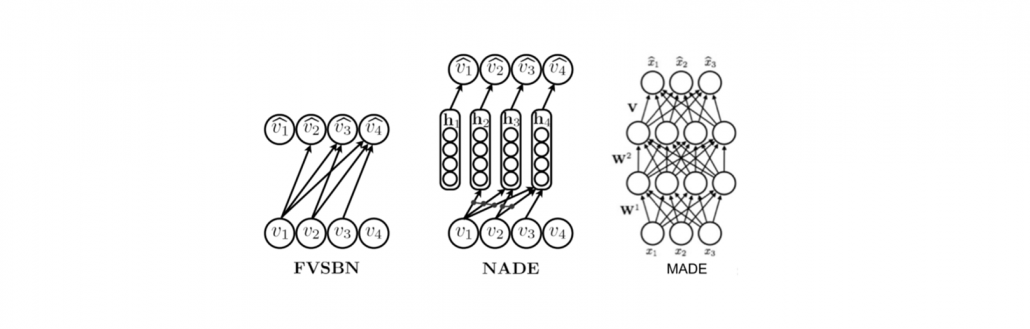

**DISCLAIMER**

The presented code is not optimized, it serves an educational purpose. It is written for CPU, it uses only fully-connected networks and an extremely simplistic dataset. However, it contains all components that can help to understand how an autoregressive model (ARM) works, and it should be rather easy to extend it to more sophisticated models. This code could be run almost on any laptop/PC, and it takes a couple of minutes top to get the result.

### Dataset

In this example, we go wild and use a dataset that is simpler than MNIST! We use a scipy dataset called Digits. It consists of ~1500 images of size 8x8, and each pixel can take values in $\{0, 1, \ldots, 16\}$.

The goal of using this dataset is that everyone can run it on a laptop, without any gpu etc.

In [21]:
# Define a PyTorch Dataset for loading the Digits dataset

class Digits(Dataset):
    """Scikit-Learn Digits dataset."""

    def __init__(self, mode='train', transforms=None):
        digits = load_digits()
        print(digits.data.shape)
        if mode == 'train':
            # Training data: first 1000 samples
            self.data = digits.data[:1000].astype(np.float32)
        elif mode == 'val':
            # Validation data: samples 1000 to 1350
            self.data = digits.data[1000:1350].astype(np.float32)
        else:
            # Test data: remaining samples
            self.data = digits.data[1350:].astype(np.float32)

        self.transforms = transforms

    def __len__(self):
        # Return the number of samples
        return len(self.data)

    def __getitem__(self, idx):
        # Get a specific sample
        sample = self.data[idx]
        if self.transforms:
            sample = self.transforms(sample)
        return sample

### ARM code

### 🌟 Purpose

This code defines a **causal 1D convolution layer** for sequence data (like time series, audio, or text).

* **Causal** means the output at time `t` depends only on the **current and past inputs**, never on the future.
* This is important for **time-series forecasting** or any real-time model where you shouldn’t "peek" at the future.

---

### 🧩 What’s happening in the code?

#### 1. **Initialization (`__init__`)**

```python
def __init__(self, in_channels, out_channels, kernel_size, dilation, A=False, **kwargs):
```

* `in_channels` = number of input features (e.g., 1 for a univariate time series, >1 for multivariate).
* `out_channels` = number of filters (features the conv layer will learn).
* `kernel_size` = how many time steps the filter looks at once.
* `dilation` = spacing between filter points (lets it see farther back in time without increasing kernel size).
* `A` = a small tweak flag that changes padding behavior (explained below).

---

#### 2. **Padding Calculation**

```python
self.padding = (kernel_size - 1) * dilation + A * 1
```

* Padding = extra zeros added to the **left** of the sequence so the convolution doesn't "see the future".
* Example: if kernel\_size=3, dilation=1 → padding=2 (so the filter looks only at past values).
* If `A=True`, padding is **one more** to keep alignment.

---

#### 3. **Defining the Conv Layer**

```python
self.conv1d = torch.nn.Conv1d(in_channels, out_channels,
                              kernel_size, stride=1,
                              padding=0,
                              dilation=dilation,
                              **kwargs)
```

* A normal **1D convolution**, but with **padding=0** because we handle padding manually (to enforce causality).

---

#### 4. **Forward Pass**

```python
x = torch.nn.functional.pad(x, (self.padding, 0))
```

* Pads the input **on the left only** → ensures causality.
* Example: `[x1, x2, x3]` → `[0, 0, x1, x2, x3]` before convolution.

```python
conv1d_out = self.conv1d(x)
```

* Applies convolution filters.

```python
if self.A:
    return conv1d_out[:, :, : -1]
else:
    return conv1d_out
```

* If `A=True`, the last output step is trimmed (because of the extra padding).

---

### 📊 Example in Plain Words

Imagine a forecasting model:

* At **time t**, you want to predict something using `[x1, x2, …, xt]`.
* **CausalConv1d** guarantees the filter won’t "cheat" by looking at `xt+1`.
* Padding makes sure early time steps also get valid outputs (instead of shrinking the sequence).

---

✅ **In short:**
This layer is just like a normal 1D convolution, but carefully padded so that **outputs never use future inputs**. That’s why it’s called **causal**.



In [22]:
# Define a causal 1D convolution layer
class CausalConv1d(nn.Module):
    """
    A causal 1D convolution.
    """

    def __init__(self, in_channels, out_channels, kernel_size, dilation, A=False, **kwargs):
        super(CausalConv1d, self).__init__()

        # Set layer attributes
        self.kernel_size = kernel_size
        self.dilation = dilation
        self.A = A
        
        # Calculate the necessary padding
        self.padding = (kernel_size - 1) * dilation + A * 1

        # Define a 1D convolutional layer with the specified parameters
        self.conv1d = torch.nn.Conv1d(in_channels, out_channels,
                                      kernel_size, stride=1,
                                      padding=0,
                                      dilation=dilation,
                                      **kwargs)

    def forward(self, x):
        # Pad the input and apply the convolution
        x = torch.nn.functional.pad(x, (self.padding, 0))
        conv1d_out = self.conv1d(x)
        if self.A:
            # If A is True, trim the last output element
            return conv1d_out[:, :, : -1]
        else:
            return conv1d_out

### 🌟 Purpose

This function defines a **log-categorical loss function**.

* It measures how well a model’s predicted probability distribution `p` matches the true class labels `x`.
* Similar idea to **cross-entropy loss**, but implemented manually.
* Often used in classification tasks where each input belongs to one of `num_classes` categories (like pixels in an image, or discrete audio values).

---

### 🧩 Code Breakdown

#### 1. Small constant

```python
EPS = 1.e-5
```

* A tiny number to prevent `log(0)` (which is undefined).
* Later, probabilities are "clamped" so they never hit exactly 0 or 1.

---

#### 2. One-hot encoding

```python
x_one_hot = F.one_hot(x.long(), num_classes=num_classes)
```

* If `x` contains class indices (e.g. `[2, 0, 3]`),
  one-hot turns it into binary vectors, e.g.

  ```
  2 → [0,0,1,0]
  0 → [1,0,0,0]
  3 → [0,0,0,1]
  ```

---

#### 3. Log probabilities

```python
log_p = x_one_hot * torch.log(torch.clamp(p, EPS, 1. - EPS))
```

* `p` = predicted probabilities for all classes.
* `torch.clamp(p, EPS, 1. - EPS)` ensures no probability is exactly 0 or 1.
* `torch.log(...)` = log-probabilities.
* Multiply by `x_one_hot` → selects only the log probability of the **true class**.
  (Because only the true class has a `1` in the one-hot vector, others are `0`.)

So, if true class = 2, it extracts `log(p_class2)`.

---

#### 4. Reduction (how to combine values)

```python
if reduction == 'avg':
    return torch.mean(log_p, dim)
elif reduction == 'sum':
    return torch.sum(log_p, dim)
else:
    return log_p
```

* `'avg'`: take mean over a dimension (`dim`).
* `'sum'`: sum over a dimension.
* `None`: return the raw log probabilities.

---

### 📊 Example

Suppose:

* `x = [2]` (true class is 2)
* `p = [0.1, 0.2, 0.7]` (model predicts class 2 with 70% probability)

Steps:

1. `x_one_hot = [0,0,1]`
2. `log_p = [0,0, log(0.7)] = log(0.7)`
3. If `reduction='sum'` → just `log(0.7)`

So the loss tells us how "surprised" the model is about the true class.

---

✅ **In short:**
This is a **custom categorical log-likelihood function**. It computes the log-probability of the correct class from the model’s predicted distribution, with options to average, sum, or keep raw values.


In [23]:
# Small constant for numerical stability
EPS = 1.e-5

# Log categorical loss function
def log_categorical(x, p, num_classes=256, reduction=None, dim=None):
    # Convert input to one-hot encoding
    x_one_hot = F.one_hot(x.long(), num_classes=num_classes)
    # Calculate log probabilities
    log_p = x_one_hot * torch.log(torch.clamp(p, EPS, 1. - EPS))
    # Return mean or sum of log probabilities as specified
    if reduction == 'avg':
        return torch.mean(log_p, dim)
    elif reduction == 'sum':
        return torch.sum(log_p, dim)
    else:
        return log_p

Below is an **autoregressive discrete model** that learns a joint distribution over a vector $x \in \{0,\dots,\text{num\_vals}-1\}^D$ by factoring it into conditionals:

$$
p(x) = \prod_{d=0}^{D-1} p(x_d \mid x_{<d})
$$

It’s meant for **discretized sequences/vectors** (e.g., 8-bit values with `num_vals=256`). The network `net` must be **causal** so that output for position $d$ depends only on positions `< d` (e.g., your `CausalConv1d`).

---

## What each part does

### Constructor

```python
class ARM(nn.Module):
    def __init__(self, net, D=2, num_vals=256):
        self.net = net         # the causal network producing logits per position
        self.num_vals = num_vals
        self.D = D             # sequence length / number of dimensions
```

* `net` should map a tensor of shape `(B, 1, D)` to logits of shape `(B, num_vals, D)` (one categorical distribution per position).

### f(x): turn inputs into per-position class probabilities

```python
def f(self, x):
    h = self.net(x.unsqueeze(1))  # (B, 1, D) -> (B, num_vals, D)  (logits)
    h = h.permute(0, 2, 1)        # -> (B, D, num_vals)
    p = torch.softmax(h, 2)       # probabilities over classes at each position
    return p
```

* Adds a channel dim so Conv1d works.
* Permutes so dimension 2 is the **class axis** for `softmax`.
* Result `p` is shape `(B, D, num_vals)` and sums to 1 across the last dim.

### forward(x): training loss (negative log-likelihood)

```python
def forward(self, x, reduction='avg'):
    return -(self.log_prob(x).mean() or .sum())
```

* Calls `log_prob` and **negates** it to get an NLL loss.
* `'avg'` = mean over batch; `'sum'` = sum over batch.

### log\_prob(x): log-likelihood of data under the model

```python
def log_prob(self, x):
    mu_d = self.f(x)  # (B, D, num_vals)
    log_p = log_categorical(x, mu_d, num_classes=self.num_vals,
                            reduction='sum', dim=-1)  # (B, D)
    return log_p.sum(-1)  # (B,)
```

* Computes $\sum_d \log p(x_d \mid x_{<d})$ for each sample.
* `log_categorical` one-hots `x` and grabs the log-prob of the true class at each position.

### sample(batch\_size): ancestral sampling

```python
def sample(self, batch_size):
    x_new = torch.zeros((batch_size, self.D))
    for d in range(self.D):
        p = self.f(x_new)                     # (B, D, num_vals), valid because net is causal
        x_new_d = torch.multinomial(p[:, d, :], num_samples=1)  # sample class at position d
        x_new[:, d] = x_new_d[:, 0]
    return x_new
```

* Builds samples **left-to-right**:

  1. Start with all zeros (a placeholder/context).
  2. Get probabilities for all positions from the causal net.
  3. Sample the current position $d$ from `p[:, d, :]`.
  4. Write it back, then move to $d+1$.
* Because `net` is **causal**, `p[:, d, :]` depends only on already-filled positions `< d`.

---

## Shapes & data types (quick sanity check)

* **Input to `forward/log_prob`:** `x` should be integer class indices, shape `(B, D)`, dtype `long`.
* **Net output:** logits `(B, num_vals, D)`.
* **`f(x)` output:** probabilities `(B, D, num_vals)`.
* **`log_prob` output:** `(B,)` per sample log-likelihood.
---

### TL;DR

* `ARM` learns a **categorical distribution per position** conditioned on the past (via a **causal `net`**).
* Training minimizes **negative log-likelihood** over the sequence.
* Sampling generates sequences **one position at a time** using the learned conditionals.


In [24]:
# Define the Autoregressive Model (ARM)
class ARM(nn.Module):
    def __init__(self, net, D=2, num_vals=256):
        super(ARM, self).__init__()

        self.net = net
        self.num_vals = num_vals
        self.D = D

    def f(self, x):
        # Forward pass through the network
        h = self.net(x.unsqueeze(1))

        # Permute dimensions for softmax
        h = h.permute(0, 2, 1)
        p = torch.softmax(h, 2)
        return p
        
    def forward(self, x, reduction='avg'):
        # Calculate negative log likelihood
        if reduction == 'avg':
            return -(self.log_prob(x).mean())
        elif reduction == 'sum':
            return -(self.log_prob(x).sum())
        else:
            raise ValueError('reduction could be either `avg` or `sum`.')

    def log_prob(self, x):
        # Compute log probability
        mu_d = self.f(x)
        log_p = log_categorical(x, mu_d, num_classes=self.num_vals, reduction='sum', dim=-1).sum(-1)
        
        return log_p

    def sample(self, batch_size):
        # Sample new data points
        x_new = torch.zeros((batch_size, self.D))

        for d in range(self.D):
            p = self.f(x_new)
            x_new_d = torch.multinomial(p[:, d, :], num_samples=1)
            x_new[:, d] = x_new_d[:,0]

        return x_new

### Auxiliary functions: training, evaluation, plotting

In [82]:
# Function to evaluate the model
def evaluation(test_loader, name=None, model_best=None, epoch=None):
    # EVALUATION
    if model_best is None:
        # Load best performing model
        state = torch.load(name + '.ckpt')  # works with default weights_only=True
        model_best = ARM(model.net, D=model.D, num_vals=model.num_vals)  # or rebuild the same net
        model_best.load_state_dict(state)

    model_best.eval()
    loss = 0.
    N = 0.
    for indx_batch, test_batch in enumerate(test_loader):
        # Compute the loss for the test batch
        loss_t = model_best.forward(test_batch, reduction='sum')
        loss = loss + loss_t.item()
        N = N + test_batch.shape[0]
    loss = loss / N

    if epoch is None:
        print(f'FINAL LOSS: nll={loss}')
    else:
        print(f'Epoch: {epoch}, val nll={loss}')

    return loss

# Function to visualize real samples
def samples_real(name, test_loader):
    # REAL-------
    num_x = 4
    num_y = 4
    x = next(iter(test_loader)).detach().numpy()

    fig, ax = plt.subplots(num_x, num_y)
    for i, ax in enumerate(ax.flatten()):
        plottable_image = np.reshape(x[i], (8, 8))
        ax.imshow(plottable_image, cmap='gray')
        ax.axis('off')

    plt.savefig(name+'_real_images.pdf', bbox_inches='tight')
    plt.close()

# Function to visualize generated samples
def samples_generated(name, data_loader, extra_name=''):
    x = next(iter(data_loader)).detach().numpy()

    # GENERATIONS-------
    # model_best = torch.load(name + '.model')
    # device = next(model.parameters()).device
    state = torch.load(name + '.ckpt')  # works with default weights_only=True
    model_best = ARM(model.net, D=model.D, num_vals=model.num_vals)  # or rebuild the same net
    model_best.load_state_dict(state)
    model_best.eval()
    # model_best.eval()

    num_x = 4
    num_y = 4
    x = model_best.sample(num_x * num_y)
    x = x.detach().numpy()

    fig, ax = plt.subplots(num_x, num_y)
    for i, ax in enumerate(ax.flatten()):
        plottable_image = np.reshape(x[i], (8, 8))
        ax.imshow(plottable_image, cmap='gray')
        ax.axis('off')

    plt.savefig(name + '_generated_images' + extra_name + '.pdf', bbox_inches='tight')
    plt.close()

# Function to plot the NLL curve
def plot_curve(name, nll_val):
    plt.plot(np.arange(len(nll_val)), nll_val, linewidth='3')
    plt.xlabel('epochs')
    plt.ylabel('nll')
    plt.savefig(name + '_nll_val_curve.pdf', bbox_inches='tight')
    plt.close()

In [72]:
# Training procedure for the ARM
def training(name, max_patience, num_epochs, model, optimizer, training_loader, val_loader):
    nll_val = []
    best_nll = 1000.
    patience = 0

    # Main loop
    for e in range(num_epochs):
        # TRAINING
        model.train()
        for indx_batch, batch in enumerate(training_loader):
            if hasattr(model, 'dequantization'):
                if model.dequantization:
                    batch = batch + torch.rand(batch.shape)
            loss = model.forward(batch)

            optimizer.zero_grad()
            loss.backward(retain_graph=True)
            optimizer.step()

        # Validation
        loss_val = evaluation(val_loader, model_best=model, epoch=e)
        nll_val.append(loss_val)  # save for plotting

        if e == 0:
            print('saved!')
            torch.save(model, name + '.model')
            best_nll = loss_val
        else:
            if loss_val < best_nll:
                print('saved!')
                # torch.save(model, name + '.model')
                torch.save(model.state_dict(), name + '.ckpt')
                best_nll = loss_val
                patience = 0

                samples_generated(name, val_loader, extra_name="_epoch_" + str(e))
            else:
                patience = patience + 1

        if patience > max_patience:
            break

    nll_val = np.asarray(nll_val)

    return nll_val

### Initialize dataloaders

In [73]:
# Load datasets and create data loaders
train_data = Digits(mode='train')
val_data = Digits(mode='val')
test_data = Digits(mode='test')

training_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

# Directory for saving results
result_dir = 'results/'
if not(os.path.exists(result_dir)):
    os.mkdir(result_dir)
name = 'arm'

(1797, 64)
(1797, 64)
(1797, 64)


In [74]:
# Assuming you already have trainloader defined
data_iter = iter(training_loader)
images = next(data_iter)

print(images.shape)

torch.Size([64, 64])


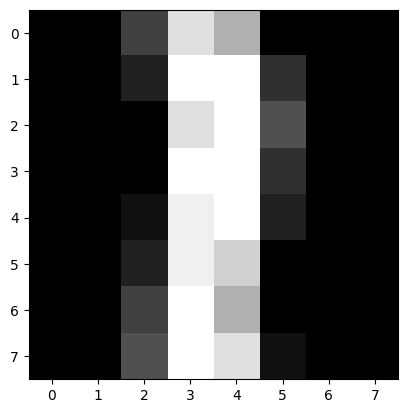

In [75]:
# reshape into 8x8 for visualization
img = images[2].view(8, 8)

plt.imshow(img, cmap="gray")
plt.title("")
plt.axis("on")
plt.show()

In [76]:
images[7]

tensor([ 0.,  0., 10., 11.,  4.,  0.,  0.,  0.,  0.,  0., 10., 15., 13., 13.,
         1.,  0.,  0.,  0.,  8., 11.,  0., 14.,  4.,  0.,  0.,  0.,  0., 13.,
        15., 13.,  0.,  0.,  0.,  1., 11., 16., 16.,  0.,  0.,  0.,  0.,  1.,
        15.,  3.,  9., 10.,  0.,  0.,  0.,  0., 14.,  6., 15., 10.,  0.,  0.,
         0.,  0.,  8., 14.,  7.,  1.,  0.,  0.])

### Hyperparams

In [77]:
D = 64   # input dimension
M = 256  # the number of neurons in scale (s) and translation (t) nets

lr = 1e-3 # learning rate
num_epochs = 10 # max. number of epochs
max_patience = 20 # an early stopping is used, if training doesn't improve for longer than 20 epochs, it is stopped

### Initialize ARM

In [78]:
likelihood_type = 'categorical'

num_vals = 17

kernel = 7

net = nn.Sequential(
    CausalConv1d(in_channels=1, out_channels=M, dilation=1, kernel_size=kernel, A=True, bias=True),
    nn.LeakyReLU(),
    CausalConv1d(in_channels=M, out_channels=M, dilation=1, kernel_size=kernel, A=False, bias=True),
    nn.LeakyReLU(),
    CausalConv1d(in_channels=M, out_channels=M, dilation=1, kernel_size=kernel, A=False, bias=True),
    nn.LeakyReLU(),
    CausalConv1d(in_channels=M, out_channels=num_vals, dilation=1, kernel_size=kernel, A=False, bias=True))

# create the model
model = ARM(net, D=D, num_vals=num_vals)

# Print the summary (like in Keras)
print(summary(model, torch.zeros(1, 64), show_input=False, show_hierarchical=False))

ARM by JT.
-----------------------------------------------------------------------
      Layer (type)        Output Shape         Param #     Tr. Param #
    CausalConv1d-1        [1, 256, 64]           2,048           2,048
       LeakyReLU-2        [1, 256, 64]               0               0
    CausalConv1d-3        [1, 256, 64]         459,008         459,008
       LeakyReLU-4        [1, 256, 64]               0               0
    CausalConv1d-5        [1, 256, 64]         459,008         459,008
       LeakyReLU-6        [1, 256, 64]               0               0
    CausalConv1d-7         [1, 17, 64]          30,481          30,481
Total params: 950,545
Trainable params: 950,545
Non-trainable params: 0
-----------------------------------------------------------------------


## What you’re configuring

* **D = 64** → each training example is a length-64 sequence of integers (class indices).
* **num\_vals = 17** → each position can take one of 17 discrete values (so it’s a 17-way classification at every step).
* **M = 256** → channel width (number of feature maps) inside the conv stack.
* **kernel = 7** → each conv looks back over a window of 7 time steps.

## The network (`net`)

You’re stacking **causal 1D convolutions** to model $p(x_d \mid x_{<d})$ for every position $d$.

```python
net = nn.Sequential(
    CausalConv1d(1,   M, kernel=7, dilation=1, A=True,  bias=True),  # “Type A” masked conv
    nn.LeakyReLU(),
    CausalConv1d(M,   M, kernel=7, dilation=1, A=False, bias=True),  # “Type B” masked convs
    nn.LeakyReLU(),
    CausalConv1d(M,   M, kernel=7, dilation=1, A=False, bias=True),
    nn.LeakyReLU(),
    CausalConv1d(M, num_vals, kernel=7, dilation=1, A=False, bias=True)  # logits over 17 classes
)
```

### Why `A=True` only in the first layer?

* `A=True` pads **one extra** on the left and then drops the last output element.
* This enforces **strict** causality at the very first layer: the output at time $t$ **cannot** use $x_t$ itself—only $x_{<t}$. (This mirrors “masked conv A” in PixelCNN.)
* Subsequent layers use `A=False` (“masked conv B”): they can look at features at time $t$ because those features are already guaranteed to depend only on the past.

### Receptive field (how far back the model can see)

* You have 3 hidden convs + 1 output conv, all with kernel 7 and dilation 1.
* Each layer adds $k-1 = 6$ steps of look-back.
* Overall the model can use up to **18 past steps** (3×6) when predicting position $t$; the first layer also ensures it never uses $x_t$ itself.

### Shapes through the model

* Input to ARM: `x` as integers of shape `(B, D)` with `D=64`.
* `ARM.f(x)` does `x.unsqueeze(1)` → `(B, 1, 64)` then runs `net` to get logits `(B, num_vals, 64)`, permutes to `(B, 64, num_vals)`, and applies softmax to get per-position class **probabilities**.

## The model wrapper (`ARM`)

```python
model = ARM(net, D=D, num_vals=num_vals)
```

* **Training:** `forward(x)` returns **negative log-likelihood** over the sequence (avg or sum over batch).
* **log\_prob(x):** sums the log-prob of the true class at each position (uses your `log_categorical`).
* **sample(batch\_size):** generates sequences left→right (ancestral sampling), drawing each $x_d$ from the predicted categorical $p(x_d \mid x_{<d})$.

That’s it: you’ve set up a **PixelCNN-style causal conv classifier per time step**, wrapped into an **autoregressive model** that trains with categorical NLL and can sample new discrete sequences of length 64 over 17 symbols.


### Let's play! Training

In [79]:
# OPTIMIZER
optimizer = torch.optim.Adamax([p for p in model.parameters() if p.requires_grad == True], lr=lr)

In [80]:
# Training procedure
nll_val = training(name=result_dir + name, max_patience=max_patience, num_epochs=num_epochs, model=model, optimizer=optimizer,
                       training_loader=training_loader, val_loader=val_loader)

Epoch: 0, val nll=121.28376255580358
saved!
Epoch: 1, val nll=113.67259068080357
saved!
ARM by JT.
Epoch: 2, val nll=110.06854282924107
saved!
ARM by JT.
Epoch: 3, val nll=108.20489118303571
saved!
ARM by JT.
Epoch: 4, val nll=106.19320452008928
saved!
ARM by JT.
Epoch: 5, val nll=103.92846749441965
saved!
ARM by JT.
Epoch: 6, val nll=101.6567431640625
saved!
ARM by JT.
Epoch: 7, val nll=99.62815150669643
saved!
ARM by JT.
Epoch: 8, val nll=97.9994921875
saved!
ARM by JT.
Epoch: 9, val nll=96.733427734375
saved!
ARM by JT.


In [83]:
test_loss = evaluation(name=result_dir + name, test_loader=test_loader)
f = open(result_dir + name + '_test_loss.txt', "w")
f.write(str(test_loss))
f.close()

samples_real(result_dir + name, test_loader)

plot_curve(result_dir + name, nll_val)

ARM by JT.
FINAL LOSS: nll=93.64559520064317


## Question 1: Experiment with Different Network Architectures

**Task**: Modify the **Net** class to experiment with different network architectures, such as adding more layers or changing the number of neurons in each layer. Evaluate how these changes affect the model's performance. Specifically, try reducing the number of convolutional layers by half and observe how the model's ability to generate digits changes.

In [29]:
reduced_net = nn.Sequential(
    CausalConv1d(in_channels=1, out_channels=M, dilation=1, kernel_size=kernel, A=True, bias=True),
    nn.LeakyReLU(),
    CausalConv1d(in_channels=M, out_channels=num_vals, dilation=1, kernel_size=kernel, A=False, bias=True))

# Instantiate the modified model
# reduced_net = ReducedNet(D, M)
reduced_model = ARM(reduced_net, D=D, num_vals = num_vals)

# Train and evaluate the modified model
optimizer = torch.optim.Adam(reduced_model.parameters(), lr=lr)
nll_val_reduced = training(result_dir + 'reduced_' + name, max_patience, num_epochs, reduced_model, optimizer, training_loader, val_loader)

plot_curve(result_dir + 'reduced_' + name, nll_val_reduced)
evaluation(test_loader, name=result_dir + 'reduced_' + name)
samples_generated(result_dir + 'reduced_' + name, test_loader)

ARM by JT.
Epoch: 0, val nll=126.06902553013393
saved!
Epoch: 1, val nll=111.91550571986608
saved!
Epoch: 2, val nll=108.28238420758929
saved!
Epoch: 3, val nll=106.16737862723214
saved!
Epoch: 4, val nll=104.79122628348215
saved!
Epoch: 5, val nll=103.83047712053572
saved!
Epoch: 6, val nll=103.34905831473215
saved!
Epoch: 7, val nll=103.00702566964286
saved!
Epoch: 8, val nll=102.36024135044643
saved!
Epoch: 9, val nll=102.0963818359375
saved!
Epoch: 10, val nll=101.21721749441964
saved!


KeyboardInterrupt: 

Observations:

1. Performance: Reducing the number of layers will typically lead to faster training times due to fewer parameters. However, the model may not capture complex dependencies as effectively, resulting in higher NLL values and potentially lower quality in generated samples.

2. Sample Quality: The generated samples might exhibit less variation and complexity compared to the original model. This is because deeper networks can learn more intricate patterns.

3. NLL Values: Compare the NLL values obtained with the original and reduced architectures to quantify the impact of network depth on performance.

## Question 2: Implement a Different Activation Function

**Task**: Replace the ReLU activation function in the Net class with a different activation function, such as Leaky ReLU or ELU, and analyze how this change affects the model's performance in terms of convergence speed, NLL, and sample quality.

In [ ]:
LeakyReLUNet = nn.Sequential(
    CausalConv1d(in_channels=1, out_channels=M, dilation=1, kernel_size=kernel, A=True, bias=True),
    nn.LeakyReLU(),
    CausalConv1d(in_channels=M, out_channels=M, dilation=1, kernel_size=kernel, A=False, bias=True),
    nn.LeakyReLU(),
    CausalConv1d(in_channels=M, out_channels=M, dilation=1, kernel_size=kernel, A=False, bias=True),
    nn.LeakyReLU(),
    CausalConv1d(in_channels=M, out_channels=num_vals, dilation=1, kernel_size=kernel, A=False, bias=True))

# Instantiate and train the model with Leaky ReLU
# leaky_relu_net = LeakyReLUNet(D, M)
leaky_relu_model = ARM(LeakyReLUNet, D=D, num_vals = num_vals)

optimizer = torch.optim.Adam(leaky_relu_model.parameters(), lr=lr)
nll_val_leaky_relu = training(result_dir + 'leaky_relu_' + name, max_patience, num_epochs, leaky_relu_model, optimizer, training_loader, val_loader)

plot_curve(result_dir + 'leaky_relu_' + name, nll_val_leaky_relu)
evaluation(test_loader, name=result_dir + 'leaky_relu_' + name)
samples_generated(result_dir + 'leaky_relu_' + name, test_loader)


ARM by JT.
Epoch: 0, val nll=116.07713936941964
saved!
Epoch: 1, val nll=109.88066057477678
saved!
Epoch: 2, val nll=105.79218610491071
saved!
Epoch: 3, val nll=100.85708356584821
saved!
Epoch: 4, val nll=96.23789202008929
saved!
Epoch: 5, val nll=93.85048409598214
saved!
Epoch: 6, val nll=92.77750139508929
saved!
Epoch: 7, val nll=92.4918798828125
saved!
Epoch: 8, val nll=91.18488839285715
saved!
Epoch: 9, val nll=91.76218191964286
Epoch: 10, val nll=91.04798828125
saved!


**Observations**:

1. Activation Function Impact:

Leaky ReLU: Helps prevent dying ReLU problems by allowing a small, non-zero gradient when the unit is not active, potentially improving convergence.

ELU: Exponential Linear Unit can improve learning by smoothing the negative side of activations.

2. Performance Metrics: Compare the convergence speed and final NLL values to see if the alternative activation functions provide any benefits over standard ReLU.
3. Sample Quality: Assess the quality of generated samples with different activation functions to understand their effect on model expressiveness.